## Import Libraries
Here, we import the necessary libraries for data processing and visualization.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

pd.options.display.float_format = "{:.3f}".format

## Set Hyperparameters
Define the hyperparameters of the dataset, including phonemes, channels, window size, and step size.


In [17]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - X_PHONEMES_N_CHANNELS_SIZE_STEP.npy
PHONEMES = ['p', 'b', 't', 'd', 'k', 'g', 'f', 'v', 's', 'z', 'm', 'i', 'ē', 'e', 'a', 'u', 'oo', 'ū', 'a(r)', 'ā', 'ī', 'oy']
CHANNELS = 3
SIZE = 10
STEP = 10

## Define plot_all_channels Function
Define a function `plot_all_channels` that takes a DataFrame and a title as inputs, and creates a figure with subplots for each channel.

In [18]:
def plot_all_channels(df, title): # Create a figure and subplots for each channel
  fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 10), sharex=True)

  for i, channel in enumerate(column_names[:-1]):
      axes[i].plot(df[channel], label=channel)
      axes[i].set_ylabel(channel)
      axes[i].legend(loc="upper left")

  # Set the x-axis label and title for the entire figure
  plt.xlabel("Sample Index")
  plt.suptitle(title)

  # Display the plot
  plt.show()

## Load Data
Load the CSV data into a Pandas dataframe and get some information on its shape and columns.


In [19]:
# Update the file path below with the path to your CSV file
csv_file_path = "data.csv"

# Read the CSV data into a Pandas DataFrame
df_og = pd.read_csv(csv_file_path, skiprows=4)

print(f"df_og.shape:{df_og.shape}")
print(f"df_og.columns:{df_og.columns}")

df_og.shape:(137044, 25)
df_og.columns:Index(['Sample Index', ' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2',
       ' EXG Channel 3', ' EXG Channel 4', ' EXG Channel 5', ' EXG Channel 6',
       ' EXG Channel 7', ' Accel Channel 0', ' Accel Channel 1',
       ' Accel Channel 2', ' Other', ' Other.1', ' Other.2', ' Other.3',
       ' Other.4', ' Other.5', ' Other.6', ' Analog Channel 0',
       ' Analog Channel 1', ' Analog Channel 2', ' Timestamp', ' Other.7',
       ' Timestamp (Formatted)'],
      dtype='object')


## Preprocess Data
Filter to only keep relevant columns, replace timestamps with a 4ms incerment since we know that's the recording frequency.

In [20]:
# Select the columns from index 1 to 5 and column index 22, then concatenate the resulting DataFrames horizontally (axis=1)
df_filtered = pd.concat([df_og.iloc[:, 1:6], df_og.iloc[:, 22]], axis=1)
# df = df_og

# Assign new column names (ZYG, DLI, OOS, OOI, BUTTON, TIMESTAMP)
column_names = ['ZYG', 'DLI', 'OOS', 'OOI', 'BUTTON', 'TIMESTAMP']
df_filtered.columns = column_names

df_filtered['TIMESTAMP'] = [i*4 for i in range(0, len(df_filtered))]

df_filtered

,ZYG,DLI,OOS,OOI,BUTTON,TIMESTAMP
0,0.000,0.000,0.000,0.000,0.000,0
1,-889.957,8233.310,99273.932,-10246.576,-294.507,4
2,-896.394,8230.091,99285.197,-10245.503,-335.813,8
3,-889.957,8227.409,99290.562,-10253.013,-357.270,12
4,-882.983,8223.117,99272.323,-10256.232,-330.448,16
...,...,...,...,...,...,...
137039,-486.016,11618.258,75544.962,-14620.187,-683.427,548156
137040,-486.016,11619.867,75547.645,-14609.994,-666.797,548160
137041,-488.699,11622.549,75555.155,-14618.577,-659.287,548164
137042,-487.626,11624.695,75550.327,-14619.114,-664.115,548168


## Plot Raw EMG Channels
Plot the raw EMG channels using the `plot_all_channels` function.

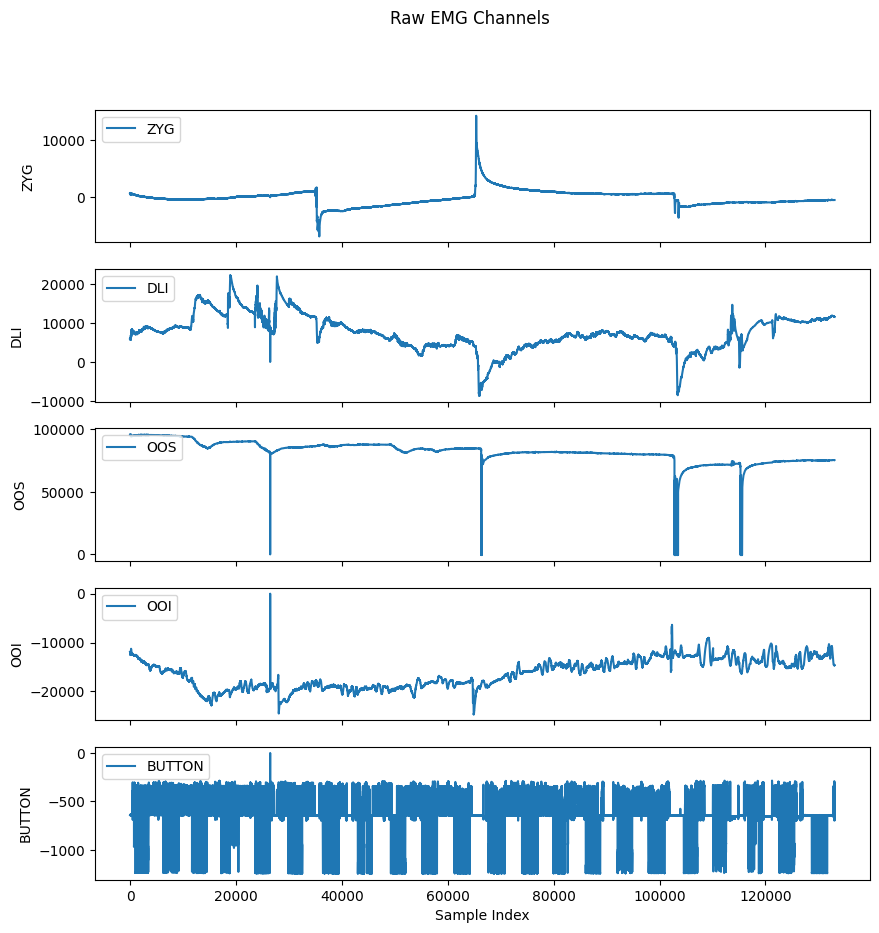

In [21]:
# Remove first 4000 rows because of bad data
CUTOFF = 4000
df = df_filtered.iloc[CUTOFF:]

df = df.reset_index(drop=True)

# Plot
plot_all_channels(df, "Raw EMG Channels")

## Outliers Removal and Data Normalization
Replace outliers with a mean of surrounding values, then normalize the data using Min-Max normalization, round "BUTTON" values to 0 or 1, and create a new DataFrame `df_normalized`.

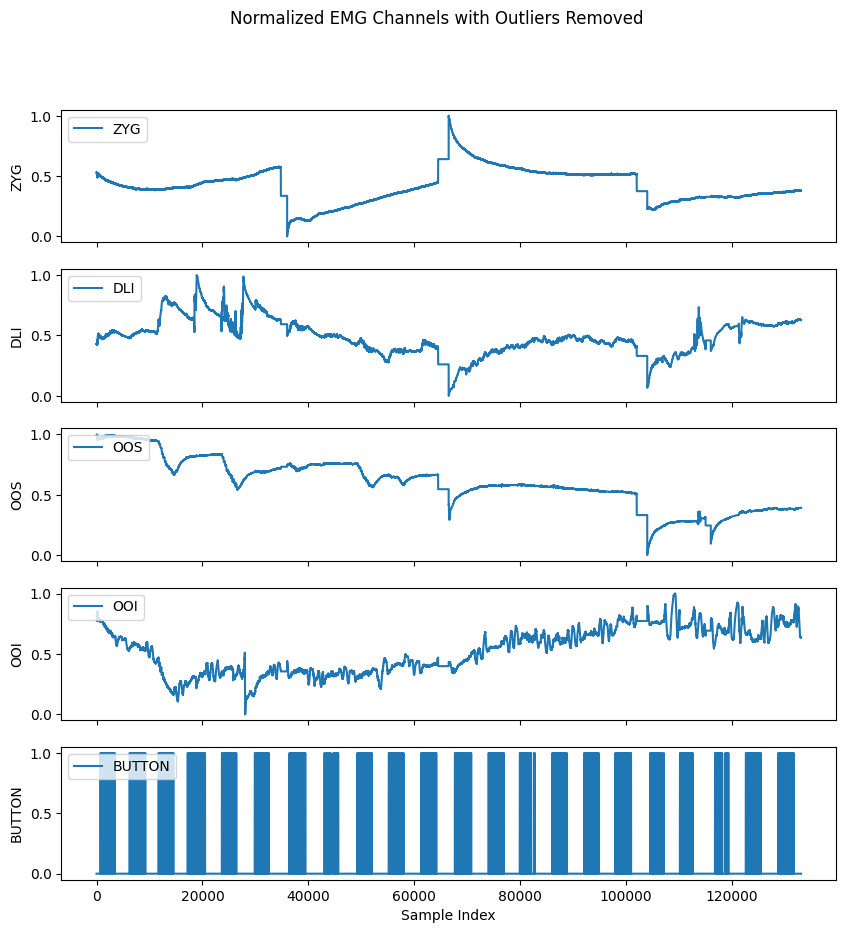

In [22]:
# Backup the "TIMESTAMP" column before removing outliers and normalization
timestamp_col = df["TIMESTAMP"].copy()

# Manually remove outliers by replacing with mean of surrounding values
df.iloc[26468:26474] = df.iloc[np.r_[26458:26468, 26474:26484]].mean()
df.iloc[34800:36000] = df.iloc[np.r_[33800:34800, 36000:37000]].mean()
df.iloc[64500:66500] = df.iloc[np.r_[62500:64500, 66500:68500]].mean()
df.iloc[102000:104000] = df.iloc[np.r_[100000:102000, 104000:106000]].mean()
df.iloc[115000:116000] = df.iloc[np.r_[114000:115000, 116000:117000]].mean()

# Drop the "TIMESTAMP" column before normalizing
df_no_timestamp = df.drop("TIMESTAMP", axis=1)

# Normalize the data using Min-Max normalization
df_normalized = (df_no_timestamp - df_no_timestamp.min()) / (df_no_timestamp.max() - df_no_timestamp.min())

# Round "BUTTON" values to 0 or 1
df_normalized["BUTTON"] = df_normalized["BUTTON"].round()

# Flip values for convenience
df_normalized['BUTTON'] = df_normalized['BUTTON'].apply(lambda x: 1 if x == 0 else 0)

# Re-insert the "TiTIMESTAMPmestamp" column
df_normalized.insert(0, "TIMESTAMP", timestamp_col)

# Plot
plot_all_channels(df_normalized, "Normalized EMG Channels with Outliers Removed")

## Define plot_rolling_channel_4 and segment_stats Functions
Define two functions: `plot_rolling_channel_4` for plotting the rolling maximum of "BUTTON" with different ranges, and `segment_stats` for calculating statistics about the segments.

In [23]:
def plot_rolling_channel_4(title, tick_gap = 2500, start=None, end=None, df = df_normalized):
  # # Do proper data cut based on arguments
  if start is None:
    start = 0
  if end is None:
    end = len(df)

  # Plot the original data and the rolling mean on a number line
  plt.figure(figsize=(16, 4))
  # plt.plot(df.index, df['EXG Channel 4'], label='Original Data', alpha=0.5)
  plt.plot(df[start:end].index, df['rolling_max'][start:end], linewidth=1)
  plt.xlabel('Index')
  plt.ylabel('Activation')

  plt.xticks(list(range(start, end, tick_gap)))

  plt.title(title)
  plt.show()

def segment_stats(df, segments):
    # Calculate statistics about the list of segments
    num_segments = len(segments)  # Number of segments
    segment_lengths = [end - start for start, end in segments]  # Lengths of each segment in terms of indices

    # Calculate the average segment length
    average_length = np.around(np.mean(segment_lengths), 2)

    # Calculate the minimum and maximum segment length
    min_length = np.min(segment_lengths)
    max_length = np.max(segment_lengths)

    # Calculate the segment lengths in terms of time (milliseconds) using the "TIMESTAMP" column
    segment_lengths_ms = [(df.loc[end, 'TIMESTAMP'] - df.loc[start, 'TIMESTAMP']) for start, end in segments]

    # Calculate the mean, min, and max segment lengths in milliseconds
    mean_length_ms = np.around(np.mean(segment_lengths_ms), 2)
    min_length_ms = np.around(np.min(segment_lengths_ms), 2)
    max_length_ms = np.around(np.max(segment_lengths_ms), 2)

    # Print the statistics
    print(f"\nSegments: {segments}")
    print(f"Number of segments: {num_segments}")
    print(f"Average segment length: {average_length} values")
    print(f"Minimum segment length: {min_length} values")
    print(f"Maximum segment length: {max_length} values")
    print(f"Average segment length (ms): {mean_length_ms} ms")
    print(f"Minimum segment length (ms): {min_length_ms} ms")
    print(f"Maximum segment length (ms): {max_length_ms} ms")

## Add Rolling Max Column
Add a new column to the DataFrame `df_normalized` for the rolling maximum of "BUTTON" with a window size of rolling_window_size.

In [24]:
rolling_window_size = 30

# Make rolling max column
df_normalized['rolling_max'] = df_normalized['BUTTON'].rolling(window=rolling_window_size, center=True).max()

## Identify Segments
Identify the start and end indices of segments with 1s in the rolling maximum of "BUTTON".

In [25]:
# Add a new column to the dataframe to identify the change in segments between 0s and 1s
df_normalized['segment_change'] = df_normalized['rolling_max'].diff()

# Identify the start and end indices of the segments with 1s
start_indices = df_normalized[df_normalized['segment_change'] == 1].index.tolist()
end_indices = df_normalized[df_normalized['segment_change'] == -1].index.tolist()

# If the first segment starts with 1s, add the starting index to the list
first_index = df_normalized.index[0]  # Get the first index of the dataframe
if df_normalized.loc[first_index, 'rolling_max'] == 1:
    start_indices.insert(0, first_index)

# If the last segment ends with 1s, add the last index to the list
last_index = df_normalized.index[-1]  # Get the last index of the dataframe
if df_normalized.loc[last_index, 'rolling_max'] == 1:
    end_indices.append(last_index)

# Combine the start and end indices into pairs
segments = list(zip(start_indices, end_indices))

# Get segments that need to be zeroed
segments_to_delete = [(start, end) for start, end in segments if end - start < 50]

# Filter out small segments
segments = [(start, end) for start, end in segments if end - start >= 50]

print(f"segments: {segments}")
print(f"len(segments): {len(segments)}")

segments: [(734, 786), (935, 1142), (1246, 1409), (1534, 1717), (1829, 2008), (2154, 2314), (2455, 2603), (2754, 2914), (3039, 3190), (3335, 3454), (6226, 6299), (6488, 6556), (6780, 6847), (7057, 7122), (7362, 7421), (7649, 7712), (7958, 8018), (8265, 8325), (8568, 8625), (8859, 8922), (9165, 9224), (11690, 11785), (11963, 12047), (12231, 12310), (12506, 12605), (12788, 12864), (13048, 13170), (13346, 13420), (13607, 13691), (13885, 13975), (14158, 14238), (14446, 14546), (17190, 17261), (17450, 17511), (17701, 17762), (17959, 18041), (18256, 18330), (18519, 18580), (18784, 18857), (19059, 19118), (19336, 19400), (19603, 19653), (19891, 19961), (20173, 20230), (20449, 20508), (23649, 23723), (23888, 23963), (24153, 24208), (24421, 24491), (24692, 24760), (24973, 25043), (25247, 25313), (25520, 25584), (25798, 25865), (26075, 26143), (26349, 26410), (29857, 29968), (30158, 30236), (30400, 30511), (30694, 30787), (30976, 31084), (31281, 31374), (31568, 31657), (31863, 31970), (32154, 32

## Clean Recordings
Set "rolling_max" to zero in segments shorter than 50 values

In [26]:
def clean_recordings(df, segments):
  for start, end in segments:
    df.loc[(df.index >= start) & (df.index <= end), 'rolling_max'] = 0
  return df

df_normalized = clean_recordings(df_normalized, segments_to_delete)

## Group Segments
Cluster the segments into the 22 groups, one for each phoneme, based on the gap between phoneme recording sessions.

In [27]:
def group_segments(segments, gap, phonemes):
  groups = {}
  current_group = []

  i = 0

  for segment in segments:
      if not current_group:
          current_group.append(segment)
      else:
          last_segment = current_group[-1]

          # Check if the next segment starts after a gap of at least 1000
          if segment[0] > last_segment[1] + gap:
              groups[phonemes[i]] = (current_group)
              i += 1
              current_group = [segment]
          else:
              current_group.append(segment)

  # Appending the last group to the list of groups
  if current_group:
      groups[phonemes[i]] = (current_group)

  return groups

segment_dict = group_segments(segments, 1000, PHONEMES)

print(f"Total phonemes - len(segment_dict): {len(segment_dict)}")
print(f"Recordings per phoneme: {[len(segment_dict[x]) for x in PHONEMES]}")

Total phonemes - len(segment_dict): 22
Recordings per phoneme: [10, 11, 11, 13, 11, 10, 12, 9, 11, 11, 11, 12, 11, 9, 10, 10, 11, 10, 9, 8, 10, 11]


## Plot and Calculate Segment Statistics
Plot and analyze different segments of the data using the `plot_rolling_channel_4` and `segment_stats` functions.

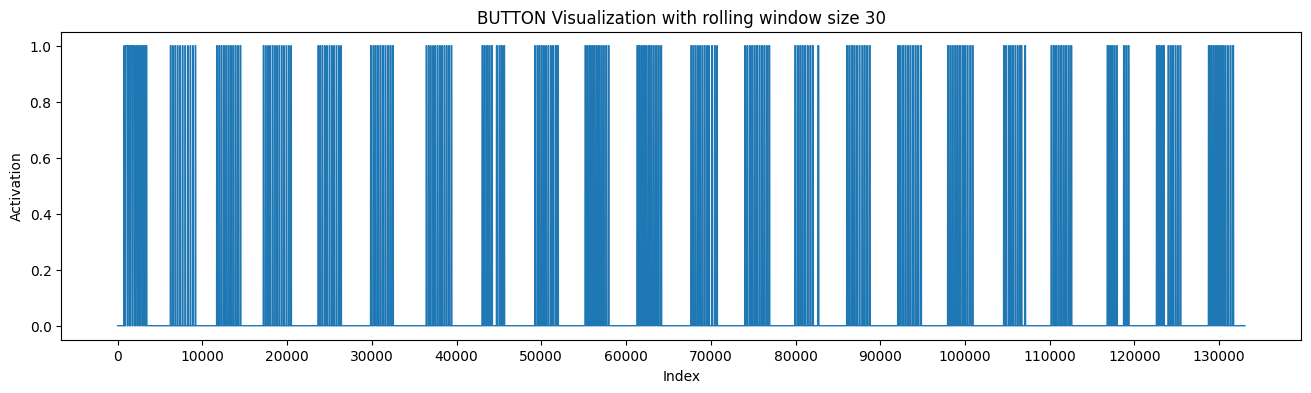


Segments: [(734, 786), (935, 1142), (1246, 1409), (1534, 1717), (1829, 2008), (2154, 2314), (2455, 2603), (2754, 2914), (3039, 3190), (3335, 3454), (6226, 6299), (6488, 6556), (6780, 6847), (7057, 7122), (7362, 7421), (7649, 7712), (7958, 8018), (8265, 8325), (8568, 8625), (8859, 8922), (9165, 9224), (11690, 11785), (11963, 12047), (12231, 12310), (12506, 12605), (12788, 12864), (13048, 13170), (13346, 13420), (13607, 13691), (13885, 13975), (14158, 14238), (14446, 14546), (17190, 17261), (17450, 17511), (17701, 17762), (17959, 18041), (18256, 18330), (18519, 18580), (18784, 18857), (19059, 19118), (19336, 19400), (19603, 19653), (19891, 19961), (20173, 20230), (20449, 20508), (23649, 23723), (23888, 23963), (24153, 24208), (24421, 24491), (24692, 24760), (24973, 25043), (25247, 25313), (25520, 25584), (25798, 25865), (26075, 26143), (26349, 26410), (29857, 29968), (30158, 30236), (30400, 30511), (30694, 30787), (30976, 31084), (31281, 31374), (31568, 31657), (31863, 31970), (32154, 3

In [28]:
plot_rolling_channel_4(f"BUTTON Visualization with rolling window size {rolling_window_size}", tick_gap = 10000)
segment_stats(df_normalized, segments)

## Remove Unneeded Columns
Remove all unneeded columns, leave the three relevant muscle groups.

In [29]:
df_final = df_normalized.drop(['TIMESTAMP', 'ZYG', 'BUTTON', 'rolling_max', 'segment_change'], axis=1)
df_final.head()

,DLI,OOS,OOI
0,0.428,0.992,0.816
1,0.428,0.992,0.816
2,0.428,0.992,0.816
3,0.428,0.992,0.816
4,0.429,0.992,0.816


## Create Silent Segments
Create an even distribution of silent segments in spaces with no button activation.

In [30]:
NUM_SILENT_SEGMENTS = 10

def generate_even_segments(segment_size, segment_count, start_index, end_index):
    segments = []
    total_length = segment_size * segment_count

    # Calculate the range between start_index and end_index
    max_range = end_index - start_index

    # Calculate the overlap or gap between segments
    overlap_gap = (total_length - max_range) // (segment_count - 1) if segment_count > 1 else 0

    for i in range(segment_count):
        start_index_segment = start_index + i * (segment_size - overlap_gap)  # Calculate start_index for each segment based on overlap or gap
        end_index_segment = start_index_segment + segment_size

        segments.append((start_index_segment, end_index_segment))

    return segments

# Between 8000 and 10000
segments_silence = generate_even_segments(100, NUM_SILENT_SEGMENTS, 89000, 92000)

## Create Dictionary of Data Segments
Split the dataframe into appropriate sections for each phoneme/recordings-list pair.

In [31]:
# Create recording arrays from df and array of (start, end) segments
def segment_data(df, segments):
  data_segments = []
  for start, end in segments:
    segment = df.iloc[start:end].to_numpy()
    data_segments.append(segment)
  return data_segments

data_segments = segment_data(df_final, segments)

data_segments_silence = segment_data(df_final, segments_silence)

data_segments_dict = dict(segment_dict)

total = 0
for key in segment_dict.keys():
  segs_num = len(segment_dict[key])

  data_segments_dict[key] = data_segments[total:total+segs_num]

  total += segs_num

print(f"len(data_segments_dict): {len(data_segments_dict)}")

len(data_segments_dict): 22


## Create training data + training labels
Using SIZE and STEP hyperparameters, use a sliding window to generate additonal data from recordings. Concatonate all these to get X_train, then generate the appropriate phoneme class labels for y_train.

In [32]:
def generate_training_examples(data_segments, SIZE, STEP):
  training_examples = []

  for segment in data_segments:
    start_index = 0
    end_index = start_index + SIZE

    while end_index <= len(segment):
      example = segment[start_index:end_index]
      training_examples.append(example)

      start_index += STEP
      end_index += STEP

  return training_examples

# Generate training examples for each phoneme and silence
train_dict = dict([(key, generate_training_examples(data_segments_dict[key], SIZE, STEP)) for key in segment_dict.keys()])

train_silence = generate_training_examples(data_segments_silence, SIZE, STEP)
print(f"# silence: {len(train_silence)}")

for key in train_dict.keys():
  print(f"# {key}: {len(train_dict[key])}")

# Concatenate training arrays
def concatenate_lists(dictionary):
    result = []  # Create empty list to store the concatenated lists

    # Loop over the values of the dictionary
    for value_list in dictionary.values():
        # Extend the result list instead of appending to flatten the list of lists
        result.extend(value_list)

    return result  # Return the concatenated lists

X_train = train_silence + concatenate_lists(train_dict)
X_train = np.transpose(np.array(X_train), (0, 2, 1))

print(f"\nX_train.shape: {X_train.shape} - {X_train.shape[0]} training examples, {X_train.shape[1]} channels (muscle groups) per example, each {X_train.shape[2]} timesteps long")

# Generate training labels for each phoneme and silence
y_train_silence = np.full(len(train_silence), 0)

# Generate the labels for the keys in train_dict using a dictionary comprehension
# The keys need to be integers, so use enumerate() to assign an index (starting from 1)
y_train_dict = {key: np.full(len(train_dict[key]), i + 1) for i, key in enumerate(train_dict.keys())}

# Concatenate the labels
def concatenate_labels(labels_dict, first_label_array):
    result = first_label_array.tolist()  # Convert the first_label_array to a list

    # Loop over the values (arrays) of the labels_dict
    for label_array in labels_dict.values():
        # Extend the result list with the elements of the label_array converted to list
        result.extend(label_array.tolist())

    return np.array(result)  # Convert the result list to an array and return it

y_train = concatenate_labels(y_train_dict, y_train_silence)

print(f"y_train.shape: {y_train.shape} - {y_train.shape[0]} training labels")

# silence: 100
# p: 148
# b: 64
# t: 94
# d: 80
# k: 69
# g: 95
# f: 85
# v: 90
# s: 91
# z: 114
# m: 122
# i: 91
# ē: 103
# e: 90
# a: 102
# u: 104
# oo: 119
# ū: 82
# a(r): 97
# ā: 81
# ī: 99
# oy: 122

X_train.shape: (2242, 3, 10) - 2242 training examples, 3 channels (muscle groups) per example, each 10 timesteps long
y_train.shape: (2242,) - 2242 training labels


## Set filename
Choose filename for saving based on hyperparameters.

In [33]:
# X_train.shape = [N, CHANNELS, SIZE]
# Filename format - _PHONEMES_N_CHANNELS_SIZE_STEP.npy

N = len(X_train)
filename = f"_first22_{N}_{CHANNELS}_{SIZE}_{STEP}.npy"

## Save traing examples/labels as .npy files

In [34]:
print(filename)
np.save(f"./X{filename}", X_train)
np.save(f"./y{filename}", y_train)

_first22_2242_3_10_10.npy
